#1. Import dependencies#

In [0]:
import tensorflow as tf
import numpy as np
import os
import pprint
from tensorflow.keras.layers import Conv2D, Dense, MaxPooling2D, Dropout, Flatten 
import pandas as pd
import matplotlib.pyplot as plt

#2.Test TPUs#

In [0]:
devices=None
try:
    device_name = os.environ['COLAB_TPU_ADDR']
    TPU_addr = 'grpc://' + device_name
    print('TPU URL:', TPU_addr)
    with tf.Session(TPU_addr) as session:
        devices=session.list_devices()
    print('TPU devices:')
    pprint.pprint(devices)
except KeyError:
    print('TPU not installed in this runtime.')
    
  

TPU URL: grpc://10.116.250.106:8470
TPU devices:
[_DeviceAttributes(/job:tpu_worker/replica:0/task:0/device:CPU:0, CPU, -1, 4767761637097841020),
 _DeviceAttributes(/job:tpu_worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 17179869184, 15320465834878527478),
 _DeviceAttributes(/job:tpu_worker/replica:0/task:0/device:TPU:0, TPU, 17179869184, 6255467983292631391),
 _DeviceAttributes(/job:tpu_worker/replica:0/task:0/device:TPU:1, TPU, 17179869184, 1977746659073531231),
 _DeviceAttributes(/job:tpu_worker/replica:0/task:0/device:TPU:2, TPU, 17179869184, 12074703543390021334),
 _DeviceAttributes(/job:tpu_worker/replica:0/task:0/device:TPU:3, TPU, 17179869184, 12298909711486255561),
 _DeviceAttributes(/job:tpu_worker/replica:0/task:0/device:TPU:4, TPU, 17179869184, 5376996096278254682),
 _DeviceAttributes(/job:tpu_worker/replica:0/task:0/device:TPU:5, TPU, 17179869184, 6975544890396513222),
 _DeviceAttributes(/job:tpu_worker/replica:0/task:0/device:TPU:6, TPU, 17179869184, 14753927292165520

#3.AUTH for google drive#

In [0]:
#import os
from google.colab import drive
drive.mount('/content/gdrive')
os.chdir("/content/gdrive/My Drive/MNIST_custom")
!ls

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive
MNIST_do.ipynb	sample_submission.csv  submission.csv  test.csv  train.csv


#4. Reading from CSVs#

(42000, 785)
x_train.shape (42000, 28, 28, 1)
y_train.shape (42000,)
(28000, 784)
x_test.shape (28000, 28, 28, 1)


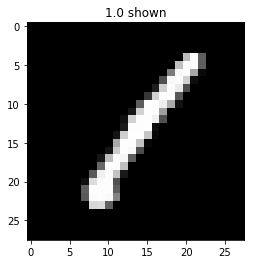

In [0]:
training_set = np.genfromtxt('train.csv',delimiter=',')[1:]
print(training_set.shape)
y_train=training_set[:,0]
x_train\
    =training_set[:, 1:].reshape((training_set.shape[0], 28, 28, 1)).astype('float32')/255.0
print("x_train.shape",x_train.shape)
print("y_train.shape",y_train.shape)


testing_set = np.genfromtxt('test.csv',delimiter=',')[1:].astype('float32')
print(testing_set.shape)
# y_test=testing_set[:,0]
x_test=testing_set[:,:].reshape((testing_set.shape[0],28, 28, 1)).astype('float32')/255.0
print("x_test.shape",x_test.shape)
# print(y_test.shape)

plt.gray()

plt.title(str(y_train[0]) + ' shown')
sample_plot = plt.imshow(x_train[0][:, :, 0])
# print(y_train[0],'shown')

#5. Build the MNIST CNN#

In [0]:
model =tf.keras.models.Sequential([
    Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(28, 28,1)),
    # Note: the first layer has to be given the input shape. After that is very automatic.
    Conv2D(32, kernel_size=(3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2,2)),
    Dropout(.2),
    
    Conv2D(64, (3, 3), activation='relu'),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2,2)),
    Dropout(.2),
    
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(.25),
    Dense(10, activation='softmax')    
])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_12 (Conv2D)           (None, 26, 26, 32)        320       
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 24, 24, 32)        9248      
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 12, 12, 32)        0         
_________________________________________________________________
dropout_9 (Dropout)          (None, 12, 12, 32)        0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 10, 10, 64)        18496     
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 8, 8, 64)          36928     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 4, 4, 64)          0         
__________

#6.Keras model to TPU: conversion#

In [0]:
tpu_model = tf.contrib.tpu.keras_to_tpu_model(
    model,
    strategy=tf.contrib.tpu.TPUDistributionStrategy(
        tf.contrib.cluster_resolver.TPUClusterResolver(tpu=TPU_addr)
    )
)
tpu_model.compile(
    optimizer = tf.train.AdamOptimizer(learning_rate=1e-3),
    loss=tf.keras.losses.sparse_categorical_crossentropy,
    metrics=['sparse_categorical_accuracy']
)


# generator: A generator or an instance of Sequence (keras.utils.Sequence) object in order to avoid duplicate data when using multiprocessing. The output of the generator must be either

# a tuple (inputs, targets)
# a tuple (inputs, targets, sample_weights).
def train_gen(batch_size):
    # the reason for using the generator function is because it does not allocate new function stacks, thus efficient
    while True:
        # First, we choose the first random starting index for the random batch
        offset = np.random.randint(0, x_train.shape[0] - batch_size)
        yield x_train[offset:offset+batch_size], y_train[offset:offset+batch_size]


INFO:tensorflow:Querying Tensorflow master (grpc://10.116.250.106:8470) for TPU system metadata.
INFO:tensorflow:Found TPU system:
INFO:tensorflow:*** Num TPU Cores: 8
INFO:tensorflow:*** Num TPU Workers: 1
INFO:tensorflow:*** Num TPU Cores Per Worker: 8
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, -1, 4767761637097841020)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 17179869184, 15320465834878527478)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 17179869184, 6255467983292631391)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 17179869184, 1977746659073531231)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 17179869184, 12074703543390021334)
INFO:tensorflow:*** Available Device: _DeviceAttribute

#7. Train the model and time it#

In [0]:
%%time
history = tpu_model.fit_generator(
    train_gen(128),
    epochs=30,
    steps_per_epoch=100
)

Epoch 1/30
100/100 [==============================] - 3s 35ms/step - loss: 0.0224 - sparse_categorical_accuracy: 0.9930
Epoch 2/30
100/100 [==============================] - 3s 34ms/step - loss: 0.0206 - sparse_categorical_accuracy: 0.9940
Epoch 3/30
100/100 [==============================] - 3s 34ms/step - loss: 0.0186 - sparse_categorical_accuracy: 0.9940
Epoch 4/30
100/100 [==============================] - 3s 35ms/step - loss: 0.0203 - sparse_categorical_accuracy: 0.9930
Epoch 5/30
100/100 [==============================] - 3s 35ms/step - loss: 0.0180 - sparse_categorical_accuracy: 0.9937
Epoch 6/30
100/100 [==============================] - 4s 36ms/step - loss: 0.0191 - sparse_categorical_accuracy: 0.9938
Epoch 7/30
100/100 [==============================] - 4s 38ms/step - loss: 0.0159 - sparse_categorical_accuracy: 0.9953
Epoch 8/30
100/100 [==============================] - 4s 36ms/step - loss: 0.0156 - sparse_categorical_accuracy: 0.9949
Epoch 9/30
100/100 [====================

In [0]:
type(tpu_model)

tensorflow.contrib.tpu.python.tpu.keras_support.KerasTPUModel

In [0]:
print(history.history)

{'loss': [0.022401340932119637, 0.020557768273283726, 0.018625712756766007, 0.020304385520284997, 0.01798742535698693, 0.01913136568677146, 0.01588189030473586, 0.015599676187266596, 0.017249223733961115, 0.016618158550118098, 0.016603410140378402, 0.014184477415037691, 0.014595625210931757, 0.014047020934449393, 0.01642313754768111, 0.01618138388643274, 0.015114746422623284, 0.011609993946622125, 0.015606227044627304, 0.013595086029235972, 0.011831375516485422, 0.01560095476132119, 0.013226754136703676, 0.009191015539108775, 0.007951931086063268, 0.011741162908365368, 0.011258222696196753, 0.017333341928897426, 0.013284748433216009, 0.0105923279558192], 'sparse_categorical_accuracy': [0.9930469, 0.99398434, 0.99398434, 0.9930469, 0.99367183, 0.9938281, 0.99531245, 0.99492186, 0.9945312, 0.9947656, 0.9950781, 0.99531245, 0.9951562, 0.9955469, 0.99492186, 0.9950781, 0.9952344, 0.9955469, 0.99492186, 0.9966406, 0.9957031, 0.99578124, 0.9952344, 0.9969531, 0.9970312, 0.99546874, 0.9963281

In [0]:
# def plot_hist(train_loss, train_acc, test_loss, test_acc):
#   fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 4))
  
#   ax1.plot(train_loss, label='train loss')
#   ax1.plot(test_loss, label='test loss')
#   ax1.set_xlabel('Epochs')
#   ax1.set_ylabel('Loss')
#   ax1.set_title('Train & Test Loss')
#   ax1.legend()
  
  
#   ax2.plot(train_acc, label='train acc')
#   ax2.plot(test_acc, label='test acc')
#   ax2.set_xlabel('Epochs')
#   ax2.set_ylabel('Accuracy')
#   ax2.set_title('Train & Test Accuracy')
#   ax2.legend()
    
#   plt.show()



def plot_hist(train_loss):
  fig, (ax1) = plt.subplots(1, 1, figsize=(4, 4))
  
  ax1.plot(train_loss, label='train loss')
  ax1.set_xlabel('Epochs')
  ax1.set_ylabel('Loss')
  ax1.legend()
    
  plt.show()


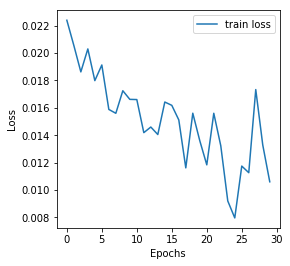

In [0]:
plot_hist(history.history['loss'])

#8.Predict the test data#

In [0]:
predicted_prob = tpu_model.predict(x_test)
predicted_classes = np.argmax(predicted_prob, axis=1)
print(predicted_classes)

INFO:tensorflow:New input shapes; (re-)compiling: mode=infer (# of cores 8), [TensorSpec(shape=(4, 28, 28, 1), dtype=tf.float32, name='conv2d_8_input_10')]
INFO:tensorflow:Overriding default placeholder.
INFO:tensorflow:Remapping placeholder for conv2d_8_input
INFO:tensorflow:Started compiling
INFO:tensorflow:Finished compiling. Time elapsed: 2.58233904838562 secs
[2 0 9 ... 3 9 2]


[6689, 10878, 9449, 12920, 2646, 11483, 1439, 12121, 14056, 19932]


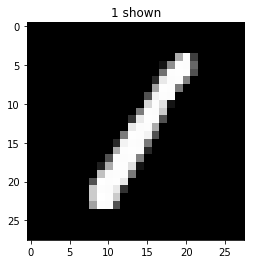

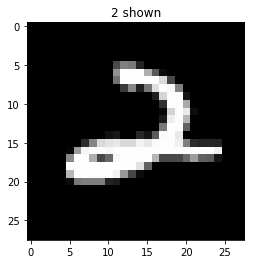

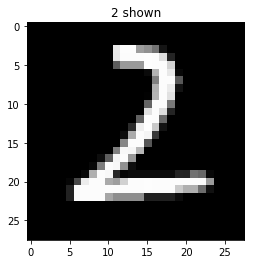

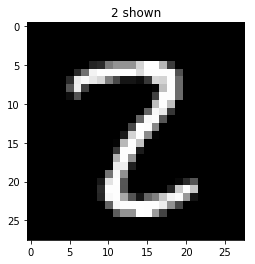

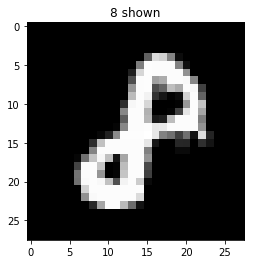

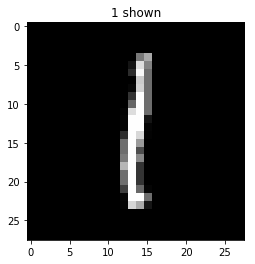

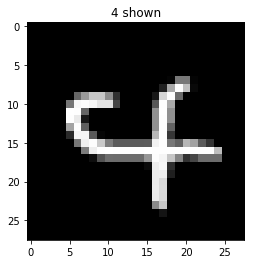

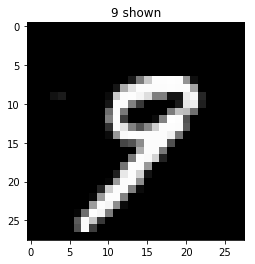

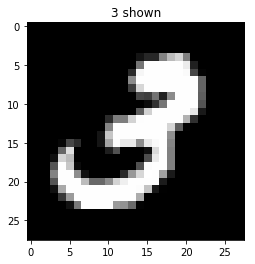

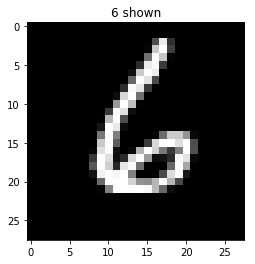

In [0]:
type(predicted_classes)

print(np.random.randint(predicted_classes.shape[0], size=10).tolist())
import time
for i in np.random.randint(predicted_classes.shape[0], size=10).tolist():
    plt.title(str(predicted_classes[i]) + ' shown')
    sample_plot = plt.imshow(x_test[i][:, :, 0])
#     time.sleep(0.01)
    plt.show()



In [0]:
indices = np.array(range(1,predicted_classes.shape[0] + 1)).reshape(predicted_classes.shape[0], 1)
v_pred = predicted_classes.reshape(predicted_classes.shape[0], 1)
print(v_pred)
result_df = pd.DataFrame(np.hstack((indices, v_pred)), columns=['ImageId', 'Label'])
print(result_df)

[[2]
 [0]
 [9]
 ...
 [3]
 [9]
 [2]]
       ImageId  Label
0            1      2
1            2      0
2            3      9
3            4      9
4            5      3
5            6      7
6            7      0
7            8      3
8            9      0
9           10      3
10          11      5
11          12      7
12          13      4
13          14      0
14          15      4
15          16      3
16          17      3
17          18      1
18          19      9
19          20      0
20          21      9
21          22      1
22          23      1
23          24      5
24          25      7
25          26      4
26          27      2
27          28      7
28          29      4
29          30      7
...        ...    ...
27970    27971      5
27971    27972      0
27972    27973      4
27973    27974      8
27974    27975      0
27975    27976      3
27976    27977      6
27977    27978      0
27978    27979      1
27979    27980      9
27980    27981      3
27981    27982    

In [0]:
result_df.to_csv('submission.csv', encoding='utf-8', index=False)

In [0]:
!ls

MNIST_do.ipynb	sample_submission.csv  submission.csv  test.csv  train.csv


# EXTRA: data augmentation#

In [0]:
# CREATE MORE IMAGES VIA DATA AUGMENTATION
datagen = tf.keras.preprocessing.image.ImageDataGenerator(
        rotation_range=10,  
        zoom_range = 0.10,  
        width_shift_range=0.1, 
        height_shift_range=0.1)

In [0]:
#Train again, with the IDG function!
%%time
history = tpu_model.fit_generator(
    datagen.flow(x_train,y_train, batch_size=128),
    epochs=20,
    steps_per_epoch=x_train.shape[0]//128
)

Epoch 1/45
329/329 [==============================] - 12s 37ms/step - loss: 0.0343 - sparse_categorical_accuracy: 0.9901
Epoch 2/45
329/329 [==============================] - 12s 37ms/step - loss: 0.0298 - sparse_categorical_accuracy: 0.9904
Epoch 3/45
329/329 [==============================] - 12s 37ms/step - loss: 0.0265 - sparse_categorical_accuracy: 0.9916
Epoch 4/45
329/329 [==============================] - 12s 37ms/step - loss: 0.0292 - sparse_categorical_accuracy: 0.9905
Epoch 5/45
329/329 [==============================] - 12s 37ms/step - loss: 0.0301 - sparse_categorical_accuracy: 0.9911
Epoch 6/45
329/329 [==============================] - 12s 37ms/step - loss: 0.0273 - sparse_categorical_accuracy: 0.9918
Epoch 7/45
329/329 [==============================] - 12s 37ms/step - loss: 0.0274 - sparse_categorical_accuracy: 0.9913
Epoch 8/45
329/329 [==============================] - 13s 38ms/step - loss: 0.0270 - sparse_categorical_accuracy: 0.9921
Epoch 9/45
329/329 [============

KeyboardInterrupt: ignored